# Fast Decaying Positional Encoding

$$ {PE}_{pos, 2i} = \frac{2i}{d_{\text{model}}} \cdot \frac{\sin(pos)}{\sqrt{pos}}$$
$$ {PE}_{pos, 2i+1} = \frac{2i+1}{d_{\text{model}}} \cdot \frac{\cos(pos)}{\sqrt{pos}}$$

In [10]:
from helper import has_duplicate_rows, draw
import torch
from torch import nn


class FastDecayingPositionalEncoding(nn.Module):
    """
    Fast Decaying Positional Encoding
    """

    def __init__(self, max_len: int, d_model: int, dropout: float = 0):
        super(FastDecayingPositionalEncoding, self).__init__()

        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.unsqueeze(torch.arange(start=1, end=max_len + 1), dim=1)  # Shape is torch.Size([max_len, 1])

        term = torch.exp(
            torch.log(torch.arange(start=1, end=d_model + 1, step=2)) -
            torch.log(torch.Tensor([d_model])) -
            (0.5 * position)
        )  # Shape is torch.Size([max_len, d_model / 2])

        pe[:, 0::2] = term * torch.sin(position)  # pe_pos_2i
        pe[:, 1::2] = term * torch.cos(position)  # pe_pos_2i+1

        pe = torch.unsqueeze(pe, dim=0)  # Shape is torch.Size([1, max_len, d_model])

        if has_duplicate_rows(pe):
            raise Warning(
                'The positional encoding matrix contains invalid encoding rows, which may result in the loss of positional information. Please reduce the value of the "max_len" parameter.')
        else:
            print('You are using an experimental feature: FastDecayingPositionalEncoding.')

        self.register_buffer(name='pe', tensor=pe)  # Buffer

    def forward(self, x: torch.Tensor):
        # x.shape = torch.Size([max_len, d_model])
        x = x + self.pe[:, :x.size(1)].requires_grad_(False)  # Prevent from calculating gradients.
        return self.dropout(x)  # Stochastically dropout elements


# Parameters
max_len = 200
d_model = 50

# Initialize module and output the data
pe = FastDecayingPositionalEncoding(max_len, d_model).pe
pe

You are using an experimental feature: FastDecayingPositionalEncoding.


tensor([[[ 1.0208e-02,  6.5542e-03,  3.0623e-02,  ...,  3.0805e-01,
           5.0017e-01,  3.2116e-01],
         [ 6.6902e-03, -3.0618e-03,  2.0071e-02,  ..., -1.4391e-01,
           3.2782e-01, -1.5003e-01],
         [ 6.2976e-04, -4.4179e-03,  1.8893e-03,  ..., -2.0764e-01,
           3.0858e-02, -2.1648e-01],
         ...,
         [-0.0000e+00, -1.4013e-45, -0.0000e+00,  ..., -9.5288e-44,
          -8.4078e-45, -9.9492e-44],
         [-1.4013e-45, -0.0000e+00, -4.2039e-45,  ..., -2.6625e-44,
          -5.3249e-44, -2.8026e-44],
         [-1.4013e-45,  0.0000e+00, -2.8026e-45,  ...,  1.6816e-44,
          -3.2230e-44,  1.8217e-44]]])

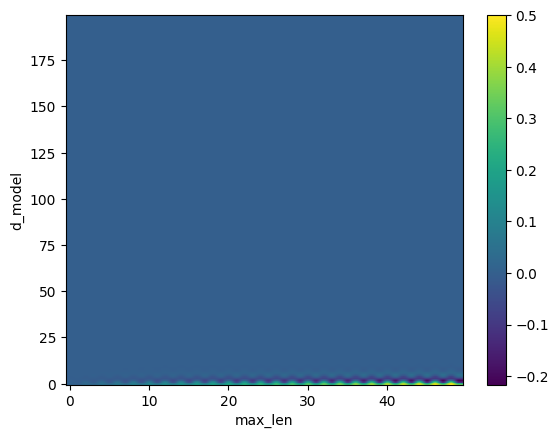

In [11]:
draw(pe)